In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
from nltk.corpus import stopwords
import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
topics = 5

In [3]:
df = pd.read_csv('data/data.csv')

In [4]:
df = df.drop(df.columns[[2, 3, 4]], axis=1)

In [5]:
df.columns

Index(['Text', 'Sentiment'], dtype='object')

In [6]:
df_good = df[df.Sentiment == '1']
df_bad = df[df.Sentiment == '0']

In [7]:
df_good = df_good.drop(df_good.columns[[1]], axis=1)
df_bad = df_bad.drop(df_bad.columns[[1]], axis=1)

In [8]:
a = df_good.sample(n=50) 
b = df_bad.sample(n=50) 

In [9]:
l = a.values.tolist()
l2 = b.values.tolist()

In [10]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [11]:
def split_pdf(string): 
    li = list(string.split(" ")) 
    return li

In [12]:
def first_clear(data):
    # Remove Emails
    data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

    #remove links and mark
    data = [re.sub('(https:\S+)|(@)|(¿)', '', sent) for sent in data]
    
    data = [re.sub('(http:\S+)|(@)|(¿)', '', sent) for sent in data]
    
    data = [re.sub('(www.:\S+)|(@)|(¿)', '', sent) for sent in data]

    # Remove new line characters
    data = [re.sub('\s+', ' ', sent) for sent in data]

    # remove spaces in begining and end
    data = [re.sub(' +', ' ', sent) for sent in data]

    # Remove distracting single quotes
    data = [re.sub("\'", "", sent) for sent in data]

    return data

In [13]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [14]:
def bi_tri_gram(data):
    bigram = gensim.models.Phrases(data, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data], threshold=100) 
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    
    return bigram_mod, trigram_mod

In [15]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [16]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

In [17]:
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [18]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [19]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [20]:
def filter_pos_tagging(data, pos):
    lista = []
    for token in data:
        for p in pos:
            if (token.pos_ == p):
                lista.append(token.text)
#                 print(token.text)

    
    return [[el] for el in lista]

In [21]:
nlp = spacy.load('en', disable=['parser', 'ner'])
mallet_path = 'mallet-2.0.8/bin/mallet' 
nlp.max_length = 20000000

# print(l[0:1])

sentiments = [l, l2]
good_bad = {}

for s in range(0, len(sentiments)):
    texto = str(sentiments[s])
    data = split_pdf(texto)
    # print(data)

    data = first_clear(data)
    # print(data)

    data = list(sent_to_words(data))

    # Remove Stop Words
    data_words_nostops = remove_stopwords(data)

    aggregate = {}
    list_pos = [['NOUN'], ['ADJ'], ['NOUN', 'ADJ']]
    
    for i in range(0, len(list_pos)):
        l = []
        data_filtered = filter_pos_tagging(nlp(str(data_words_nostops)), list_pos[i] )

        bigram_mod, trigram_mod = bi_tri_gram(data_filtered)
        # Form Bigrams
        data_words_bigrams = make_bigrams(data_filtered)
        # Initialize spacy 'en' model, keeping only tagger component (for efficiency)

        # Do lemmatization keeping only noun, adj, vb, adv
        data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

        id2word = corpora.Dictionary(data_lemmatized)
        texts = data_lemmatized
        corpus = [id2word.doc2bow(text) for text in texts]
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word, num_topics=topics,random_state=100,\
                                                update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)

        ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=topics, id2word=id2word)

        l.append(list_pos[i])
        l.append(data_lemmatized)
        l.append(id2word)
        l.append(corpus)
        l.append(lda_model)
        l.append(ldamallet)
        aggregate[i] = l
    
    good_bad[s] = aggregate


# Tópicos apenas levando em conta os Substantivos

In [22]:
pprint(good_bad[0][0][4].print_topics())
doc_lda = good_bad[0][0][4][good_bad[0][0][3]]

[(0,
  '0.030*"moment" + 0.030*"people" + 0.021*"girl" + 0.016*"shot" + '
  '0.016*"poem" + 0.016*"attempt" + 0.016*"woman" + 0.014*"wake" + '
  '0.013*"cast" + 0.013*"director"'),
 (1,
  '0.099*"movie" + 0.042*"time" + 0.026*"thing" + 0.019*"actor" + '
  '0.019*"place" + 0.017*"case" + 0.013*"steal" + 0.010*"book" + 0.009*"image" '
  '+ 0.009*"kid"'),
 (2,
  '0.099*"film" + 0.029*"point" + 0.027*"scene" + 0.025*"plot" + 0.022*"run" + '
  '0.022*"story" + 0.010*"lot" + 0.008*"folk" + 0.008*"figure" + 0.008*"work"'),
 (3,
  '0.048*"character" + 0.036*"night" + 0.031*"performance" + 0.027*"wife" + '
  '0.016*"react" + 0.014*"thriller" + 0.010*"guy" + 0.010*"way" + 0.008*"folk" '
  '+ 0.006*"bit"'),
 (4,
  '0.060*"man" + 0.028*"stewart" + 0.022*"day" + 0.022*"end" + 0.021*"life" + '
  '0.014*"nightmare" + 0.014*"watch" + 0.013*"set" + 0.010*"play" + '
  '0.010*"baby"')]


In [23]:
print('\nPerplexity: ', good_bad[0][0][4].log_perplexity(good_bad[0][0][3]))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=good_bad[0][0][4], texts=good_bad[0][0][1], dictionary=good_bad[0][0][2], coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.858607541644972

Coherence Score:  0.8420986726866566


In [24]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(good_bad[0][0][4], good_bad[0][0][3], good_bad[0][0][2])
pyLDAvis.save_html(vis, 'Sent_LDA_Noun_pos.html')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.143268 -0.005693       1        1  22.078794
0      0.035527  0.027928       2        1  22.068045
2      0.043619  0.092991       3        1  19.996677
4      0.049765 -0.118893       4        1  19.499987
3      0.014357  0.003666       5        1  16.356495, topic_info=     Category       Freq       Term      Total  loglift  logprob
0     Default  73.000000      movie  73.000000  30.0000  30.0000
77    Default  67.000000       film  67.000000  29.0000  29.0000
8     Default  39.000000        man  39.000000  28.0000  28.0000
68    Default  26.000000  character  26.000000  27.0000  27.0000
6     Default  31.000000       time  31.000000  26.0000  26.0000
...       ...        ...        ...        ...      ...      ...
502    Topic5   2.817725      blood   4.255371   1.3983  -5.2684
608    Topic5   1.752338       name   2.827343   1.3322  -5.7434
1177   Topic5   2.813233       half   6.585735   0.9600  -5.2700
1469   Topic5   4.170316       folk  28.906204  -0.1255  -4.8764
1422   Topic5   2.779738   birthday  18.730171  -0.0972  -5.2820

[202 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
878       3  0.841800  accident
611       1  0.876219    action
37        1  0.944183     actor
40        2  0.874243   actress
146       2  0.914392      anna
...     ...       ...       ...
112       5  0.787421    wonder
870       3  0.639157      word
98        3  0.861590      work
277       3  0.836435     world
16        5  0.769026      year

[186 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3, 5, 4])

In [25]:
pprint(good_bad[0][0][5].show_topics())

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=good_bad[0][0][5], texts=good_bad[0][0][1], dictionary=good_bad[0][0][2], coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  '0.167*"movie" + 0.025*"moment" + 0.020*"cast" + 0.019*"show" + 0.017*"moto" '
  '+ 0.014*"fun" + 0.014*"horror" + 0.014*"people" + 0.012*"son" + '
  '0.012*"wife"'),
 (1,
  '0.029*"life" + 0.029*"scene" + 0.025*"love" + 0.020*"year" + 0.020*"plot" + '
  '0.020*"dream" + 0.018*"part" + 0.015*"work" + 0.015*"father" + '
  '0.014*"comedy"'),
 (2,
  '0.040*"man" + 0.031*"performance" + 0.021*"director" + 0.021*"people" + '
  '0.019*"role" + 0.019*"castle" + 0.016*"wendigo" + 0.015*"world" + '
  '0.013*"killer" + 0.012*"problem"'),
 (3,
  '0.067*"time" + 0.026*"watch" + 0.026*"thing" + 0.018*"colman" + '
  '0.013*"night" + 0.013*"anna" + 0.013*"lot" + 0.011*"rock" + 0.010*"horror" '
  '+ 0.010*"music"'),
 (4,
  '0.168*"film" + 0.044*"character" + 0.040*"story" + 0.040*"actor" + '
  '0.023*"stewart" + 0.021*"play" + 0.018*"end" + 0.015*"budget" + 0.011*"pet" '
  '+ 0.011*"run"')]

Coherence Score:  0.8443806793015035


In [26]:
model_list, coherence_values = compute_coherence_values(dictionary=good_bad[0][0][2], corpus=good_bad[0][0][3], texts=good_bad[0][0][1], start=2, limit=40, step=6)


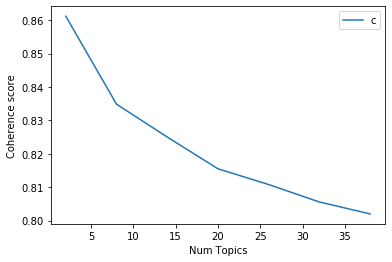

In [27]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Tópicos apenas levando em conta os Adjetivos


In [28]:
pprint(good_bad[0][1][4].print_topics())
doc_lda = good_bad[0][1][4][good_bad[0][1][3]]

[(0,
  '0.162*"great" + 0.059*"certain" + 0.053*"young" + 0.028*"last" + '
  '0.024*"natural" + 0.021*"deadly" + 0.021*"brave" + 0.020*"indian" + '
  '0.019*"technical" + 0.018*"simple"'),
 (1,
  '0.092*"much" + 0.055*"many" + 0.040*"cool" + 0.039*"better" + 0.037*"true" '
  '+ 0.035*"real" + 0.022*"beautiful" + 0.020*"accurate" + 0.019*"creative" + '
  '0.019*"satisfactory"'),
 (2,
  '0.053*"bad" + 0.042*"original" + 0.041*"kind" + 0.039*"pleasant" + '
  '0.026*"interesting" + 0.026*"sure" + 0.022*"old" + 0.020*"pretty" + '
  '0.018*"horrible" + 0.015*"personal"'),
 (3,
  '0.160*"good" + 0.033*"hard" + 0.024*"believable" + 0.021*"different" + '
  '0.019*"awkward" + 0.018*"graceful" + 0.018*"unbelievable" + 0.018*"blunt" + '
  '0.018*"vacant" + 0.018*"pregnant"'),
 (4,
  '0.064*"mad" + 0.037*"first" + 0.027*"little" + 0.027*"annoying" + '
  '0.025*"vague" + 0.025*"angry" + 0.025*"funny" + 0.019*"enough" + '
  '0.019*"late" + 0.018*"deep"')]


In [29]:
print('\nPerplexity: ', good_bad[0][1][4].log_perplexity(good_bad[0][1][3]))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=good_bad[0][1][4], texts=good_bad[0][1][1], dictionary=good_bad[0][1][2], coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.955985597447815

Coherence Score:  0.8413613872748964


In [30]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(good_bad[0][1][4], good_bad[0][1][3], good_bad[0][1][2])
pyLDAvis.save_html(vis, 'Sent_LDA_ADJ_pos.html')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.269563 -0.008738       1        1  25.920963
2     -0.056049  0.004244       2        1  19.006815
3     -0.080579 -0.188403       3        1  18.984295
1     -0.067692  0.001215       4        1  18.885260
0     -0.065243  0.191682       5        1  17.202667, topic_info=    Category       Freq             Term      Total  loglift  logprob
0    Default  34.000000             good  34.000000  30.0000  30.0000
27   Default  32.000000            great  32.000000  29.0000  29.0000
18   Default  20.000000             much  20.000000  28.0000  28.0000
274  Default  19.000000              mad  19.000000  27.0000  27.0000
407  Default  12.000000          certain  12.000000  26.0000  26.0000
..       ...        ...              ...        ...      ...      ...
404   Topic5   1.263213  cinematographic   1.843668   1.3820  -5.0353
393   Topic5   1.263213          arsenic   1.843668   1.3820  -5.0353
398   Topic5   1.263213         physical   1.843668   1.3820  -5.0353
391   Topic5   1.263213             sour   1.843668   1.3820  -5.0353
122   Topic5   1.198814            comic   1.774677   1.3678  -5.0876

[185 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
49        2  0.764267        able
195       4  0.827273    accurate
411       4  0.527422  aggressive
96        1  0.857560     amazing
92        1  0.946957    american
...     ...       ...         ...
429       2  0.885466        wide
397       4  0.527422       wifes
445       1  0.916352       witty
100       1  0.740795   wonderful
64        5  0.920139       young

[155 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 4, 2, 1])

In [31]:
pprint(good_bad[0][1][5].show_topics())

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=good_bad[0][1][5], texts=good_bad[0][1][1], dictionary=good_bad[0][1][2], coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  '0.068*"young" + 0.034*"pleasant" + 0.034*"mad" + 0.028*"indian" + '
  '0.028*"entire" + 0.028*"fine" + 0.028*"personal" + 0.028*"dark" + '
  '0.028*"strange" + 0.023*"small"'),
 (1,
  '0.076*"real" + 0.060*"late" + 0.043*"wonderful" + 0.038*"excellent" + '
  '0.038*"dead" + 0.033*"full" + 0.033*"beautiful" + 0.027*"local" + '
  '0.027*"red" + 0.027*"pretty"'),
 (2,
  '0.305*"good" + 0.040*"american" + 0.030*"classic" + 0.025*"low" + '
  '0.020*"clever" + 0.020*"simple" + 0.020*"amazing" + 0.015*"othello" + '
  '0.015*"close" + 0.015*"clear"'),
 (3,
  '0.237*"great" + 0.052*"interesting" + 0.031*"enjoyable" + 0.026*"special" + '
  '0.026*"young" + 0.021*"big" + 0.021*"horrible" + 0.015*"korean" + '
  '0.015*"believable" + 0.015*"deep"'),
 (4,
  '0.063*"original" + 0.063*"bad" + 0.048*"kind" + 0.048*"funny" + '
  '0.042*"true" + 0.037*"sematary" + 0.026*"high" + 0.021*"favorite" + '
  '0.016*"deadly" + 0.016*"successful"')]

Coherence Score:  0.8448079748676806


In [32]:
model_list, coherence_values = compute_coherence_values(dictionary=good_bad[0][1][2], corpus=good_bad[0][1][3], texts=good_bad[0][1][1], start=2, limit=40, step=6)


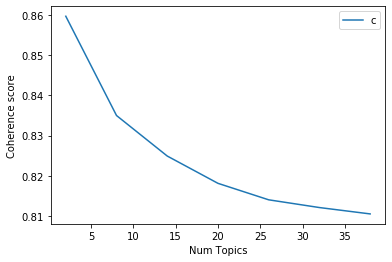

In [33]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Tópicos levando em conta os Adjetivos e Substantivos


In [34]:
pprint(good_bad[0][2][4].print_topics())
doc_lda = good_bad[0][2][4][good_bad[0][2][3]]

[(0,
  '0.056*"film" + 0.031*"great" + 0.028*"man" + 0.024*"character" + '
  '0.018*"much" + 0.018*"mad" + 0.014*"point" + 0.013*"stewart" + 0.013*"end" '
  '+ 0.011*"actor"'),
 (1,
  '0.099*"movie" + 0.026*"performance" + 0.025*"scene" + 0.024*"plot" + '
  '0.013*"young" + 0.012*"child" + 0.012*"image" + 0.010*"true" + '
  '0.009*"something" + 0.008*"guy"'),
 (2,
  '0.041*"good" + 0.017*"thing" + 0.013*"first" + 0.012*"day" + 0.012*"watch" '
  '+ 0.011*"many" + 0.011*"baby" + 0.010*"thriller" + 0.009*"case" + '
  '0.009*"lot"'),
 (3,
  '0.018*"story" + 0.017*"poem" + 0.014*"pleasant" + 0.012*"cast" + '
  '0.011*"place" + 0.011*"director" + 0.011*"hard" + 0.009*"sure" + '
  '0.009*"kind" + 0.008*"better"'),
 (4,
  '0.051*"time" + 0.034*"moment" + 0.026*"girl" + 0.025*"people" + '
  '0.017*"night" + 0.014*"set" + 0.013*"bad" + 0.011*"book" + 0.011*"funny" + '
  '0.008*"light"')]


In [35]:
print('\nPerplexity: ', good_bad[0][2][4].log_perplexity(good_bad[0][2][3]))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=good_bad[0][2][4], texts=good_bad[0][2][1], dictionary=good_bad[0][2][2], coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.144213166088699

Coherence Score:  0.8430379787408633


In [36]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(good_bad[0][2][4], good_bad[0][2][3], good_bad[0][2][2])
pyLDAvis.save_html(vis, 'Sent_LDA_Noun+ADJ_pos.html')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.160545 -0.007391       1        1  31.628672
2     -0.030144  0.027193       2        1  20.061071
3     -0.023907  0.014570       3        1  19.479950
1     -0.056021 -0.111700       4        1  16.106649
4     -0.050473  0.077328       5        1  12.723652, topic_info=     Category       Freq      Term      Total  loglift  logprob
0     Default  72.000000     movie  72.000000  30.0000  30.0000
104   Default  79.000000      film  79.000000  29.0000  29.0000
11    Default  29.000000      time  29.000000  28.0000  28.0000
1     Default  37.000000      good  37.000000  27.0000  27.0000
97    Default  43.000000     great  43.000000  26.0000  26.0000
...       ...        ...       ...        ...      ...      ...
713    Topic5   1.006734     local   1.636211   1.5760  -6.3374
548    Topic5   2.124477       odd   3.549560   1.5484  -5.5906
238    Topic5   1.584885     cross   4.082244   1.1156  -5.8836
1843   Topic5   2.559782  birthday  23.709896  -0.1643  -5.4042
1911   Topic5   1.832144      folk  15.089525  -0.0468  -5.7386

[205 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1143      1  0.880436  accident
811       1  0.821966    action
811       2  0.136994    action
50        1  0.965726     actor
53        3  0.974440   actress
...     ...       ...       ...
383       5  0.797066     world
271       5  0.899959     write
261       5  0.580945    writer
23        5  0.932840      year
247       4  0.926833     young

[212 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 4, 2, 5])

In [37]:
pprint(good_bad[0][2][5].show_topics())

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=good_bad[0][2][5], texts=good_bad[0][2][1], dictionary=good_bad[0][2][2], coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  '0.073*"good" + 0.025*"man" + 0.021*"life" + 0.017*"moment" + 0.017*"work" + '
  '0.014*"show" + 0.014*"year" + 0.014*"day" + 0.013*"late" + 0.012*"kind"'),
 (1,
  '0.051*"time" + 0.036*"character" + 0.020*"watch" + 0.018*"director" + '
  '0.017*"real" + 0.015*"american" + 0.013*"woman" + 0.013*"colman" + '
  '0.013*"series" + 0.011*"funny"'),
 (2,
  '0.054*"great" + 0.031*"story" + 0.027*"people" + 0.018*"bad" + '
  '0.017*"dream" + 0.012*"interesting" + 0.011*"problem" + 0.011*"comedy" + '
  '0.009*"performance" + 0.009*"wife"'),
 (3,
  '0.138*"film" + 0.025*"scene" + 0.018*"play" + 0.015*"original" + '
  '0.014*"wendigo" + 0.014*"moto" + 0.013*"father" + 0.011*"fun" + '
  '0.011*"killer" + 0.010*"baby"'),
 (4,
  '0.122*"movie" + 0.029*"actor" + 0.018*"thing" + 0.017*"stewart" + '
  '0.015*"role" + 0.015*"end" + 0.015*"castle" + 0.015*"plot" + 0.015*"young" '
  '+ 0.014*"part"')]

Coherence Score:  0.8447718241235671


In [38]:
model_list, coherence_values = compute_coherence_values(dictionary=good_bad[0][2][2], corpus=good_bad[0][2][3], texts=good_bad[0][2][1], start=2, limit=40, step=6)


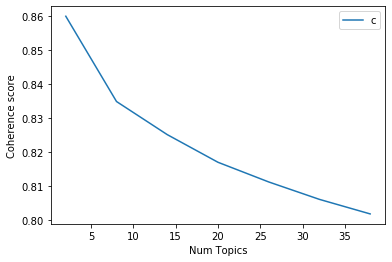

In [39]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Topicos para entradas de avaliações negativas - Substantivo

In [40]:
pprint(good_bad[1][0][4].print_topics())
doc_lda = good_bad[1][0][4][good_bad[1][0][3]]

[(0,
  '0.045*"time" + 0.033*"story" + 0.028*"nothing" + 0.021*"pay" + 0.017*"view" '
  '+ 0.015*"line" + 0.012*"teen" + 0.011*"minute" + 0.011*"bollywood" + '
  '0.011*"couple"'),
 (1,
  '0.027*"life" + 0.022*"end" + 0.022*"world" + 0.022*"love" + 0.019*"year" + '
  '0.019*"killer" + 0.017*"star" + 0.015*"atmosphere" + 0.013*"guy" + '
  '0.013*"review"'),
 (2,
  '0.031*"character" + 0.027*"man" + 0.026*"plot" + 0.025*"woman" + '
  '0.020*"head" + 0.015*"sex" + 0.013*"mother" + 0.013*"audience" + '
  '0.012*"teenager" + 0.012*"moment"'),
 (3,
  '0.093*"movie" + 0.091*"film" + 0.041*"scene" + 0.022*"death" + '
  '0.012*"survivor" + 0.012*"lesbian" + 0.011*"people" + 0.009*"watch" + '
  '0.008*"way" + 0.008*"lack"'),
 (4,
  '0.033*"slasher" + 0.033*"adult" + 0.021*"kid" + 0.018*"show" + 0.016*"evil" '
  '+ 0.016*"someone" + 0.013*"actor" + 0.013*"child" + 0.011*"care" + '
  '0.011*"idea"')]


In [41]:
print('\nPerplexity: ', good_bad[1][0][4].log_perplexity(good_bad[1][0][3]))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=good_bad[1][0][4], texts=good_bad[1][0][1], dictionary=good_bad[1][0][2], coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.569395022704763

Coherence Score:  0.8417875882412653


In [42]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(good_bad[1][0][4], good_bad[1][0][3], good_bad[1][0][2])
pyLDAvis.save_html(vis, 'Sent_LDA_Noun_neg.html')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.160388 -0.015729       1        1  29.037422
2     -0.058683 -0.138060       2        1  27.420017
0     -0.026373  0.035446       3        1  16.224434
4     -0.042778  0.077416       4        1  16.077202
1     -0.032554  0.040927       5        1  11.240929, topic_info=    Category       Freq            Term      Total  loglift  logprob
0    Default  69.000000           movie  69.000000  30.0000  30.0000
38   Default  68.000000            film  68.000000  29.0000  29.0000
33   Default  31.000000           scene  31.000000  28.0000  28.0000
27   Default  19.000000            time  19.000000  27.0000  27.0000
94   Default  22.000000       character  22.000000  26.0000  26.0000
..       ...        ...             ...        ...      ...      ...
367   Topic5   0.947834  cinematography   1.515921   1.7160  -5.7216
259   Topic5   0.878651            hope   1.453069   1.6826  -5.7974
508   Topic5   0.889581            shot   1.496650   1.6654  -5.7850
727   Topic5   1.085480             son   1.868312   1.6426  -5.5860
357   Topic5   1.195110           fairy   2.144028   1.6012  -5.4898

[201 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
153       1  0.907350   action
74        4  0.987595    actor
729       5  0.464745  actress
420       4  0.971805    adult
1094      1  0.111909      aid
...     ...       ...      ...
100       2  0.985784    woman
837       4  0.806133     word
368       5  0.858052    world
206       1  0.953294   writer
233       5  0.827724     year

[203 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 1, 5, 2])

In [43]:
pprint(good_bad[1][0][5].show_topics())

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=good_bad[1][0][5], texts=good_bad[1][0][1], dictionary=good_bad[1][0][2], coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  '0.098*"movie" + 0.044*"plot" + 0.036*"people" + 0.019*"set" + 0.019*"woman" '
  '+ 0.017*"fan" + 0.017*"year" + 0.017*"end" + 0.017*"house" + '
  '0.015*"freddy"'),
 (1,
  '0.185*"film" + 0.018*"waste" + 0.016*"work" + 0.016*"writer" + 0.016*"love" '
  '+ 0.014*"view" + 0.014*"pay" + 0.012*"eye" + 0.012*"death" + 0.010*"home"'),
 (2,
  '0.066*"character" + 0.034*"man" + 0.024*"horror" + 0.022*"thing" + '
  '0.022*"fact" + 0.020*"minute" + 0.018*"director" + 0.016*"care" + '
  '0.014*"hour" + 0.014*"moment"'),
 (3,
  '0.095*"movie" + 0.037*"story" + 0.021*"ghost" + 0.019*"place" + '
  '0.017*"world" + 0.014*"performance" + 0.014*"action" + 0.014*"money" + '
  '0.014*"line" + 0.012*"hsiao"'),
 (4,
  '0.059*"time" + 0.037*"scene" + 0.033*"actor" + 0.020*"show" + 0.018*"watch" '
  '+ 0.018*"trancer" + 0.014*"hollywood" + 0.012*"commentary" + 0.012*"family" '
  '+ 0.012*"wife"')]

Coherence Score:  0.8445939842510672


# Topicos para entradas de avaliações negativas - Adjetivos


In [44]:
pprint(good_bad[1][1][4].print_topics())
doc_lda = good_bad[1][1][4][good_bad[1][1][3]]

[(0,
  '0.073*"naked" + 0.055*"bad" + 0.041*"interested" + 0.037*"dead" + '
  '0.036*"last" + 0.034*"crazy" + 0.034*"demonic" + 0.029*"old" + 0.022*"many" '
  '+ 0.020*"interesting"'),
 (1,
  '0.131*"good" + 0.055*"cold" + 0.050*"great" + 0.037*"stupid" + 0.031*"kind" '
  '+ 0.021*"true" + 0.015*"mad" + 0.015*"close" + 0.015*"hot" + 0.014*"empty"'),
 (2,
  '0.068*"nasty" + 0.059*"enough" + 0.047*"first" + 0.039*"terrible" + '
  '0.038*"short" + 0.035*"less" + 0.030*"better" + 0.020*"japanese" + '
  '0.015*"several" + 0.015*"hard"'),
 (3,
  '0.110*"young" + 0.050*"much" + 0.047*"long" + 0.035*"female" + '
  '0.034*"explicit" + 0.034*"nymphomaniac" + 0.023*"poor" + '
  '0.022*"predictable" + 0.021*"whole" + 0.019*"american"'),
 (4,
  '0.075*"creepy" + 0.046*"little" + 0.042*"middle" + 0.019*"big" + '
  '0.018*"full" + 0.017*"original" + 0.013*"complex" + 0.013*"typical" + '
  '0.012*"potential" + 0.012*"decent"')]


In [45]:
print('\nPerplexity: ', good_bad[0][1][4].log_perplexity(good_bad[0][1][3]))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=good_bad[0][1][4], texts=good_bad[0][1][1], dictionary=good_bad[0][1][2], coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.95598559458373

Coherence Score:  0.8413613872748964


In [46]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(good_bad[0][1][4], good_bad[0][1][3], good_bad[0][1][2])
pyLDAvis.save_html(vis, 'Sent_LDA_ADJ_neg.html')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.269563 -0.008738       1        1  25.920959
2     -0.056049  0.004244       2        1  19.006815
3     -0.080579 -0.188403       3        1  18.984291
1     -0.067692  0.001215       4        1  18.885260
0     -0.065243  0.191682       5        1  17.202667, topic_info=    Category       Freq             Term      Total  loglift  logprob
0    Default  34.000000             good  34.000000  30.0000  30.0000
27   Default  32.000000            great  32.000000  29.0000  29.0000
18   Default  20.000000             much  20.000000  28.0000  28.0000
274  Default  19.000000              mad  19.000000  27.0000  27.0000
407  Default  12.000000          certain  12.000000  26.0000  26.0000
..       ...        ...              ...        ...      ...      ...
404   Topic5   1.263213  cinematographic   1.843668   1.3820  -5.0353
393   Topic5   1.263213          arsenic   1.843668   1.3820  -5.0353
398   Topic5   1.263213         physical   1.843668   1.3820  -5.0353
391   Topic5   1.263213             sour   1.843668   1.3820  -5.0353
122   Topic5   1.198814            comic   1.774677   1.3678  -5.0876

[185 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
49        2  0.764267        able
195       4  0.827273    accurate
411       4  0.527422  aggressive
96        1  0.857560     amazing
92        1  0.946957    american
...     ...       ...         ...
429       2  0.885466        wide
397       4  0.527422       wifes
445       1  0.916352       witty
100       1  0.740795   wonderful
64        5  0.920139       young

[155 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 4, 2, 1])

In [47]:
pprint(good_bad[0][1][5].show_topics())

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=good_bad[0][1][5], texts=good_bad[0][1][1], dictionary=good_bad[0][1][2], coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  '0.068*"young" + 0.034*"pleasant" + 0.034*"mad" + 0.028*"indian" + '
  '0.028*"entire" + 0.028*"fine" + 0.028*"personal" + 0.028*"dark" + '
  '0.028*"strange" + 0.023*"small"'),
 (1,
  '0.076*"real" + 0.060*"late" + 0.043*"wonderful" + 0.038*"excellent" + '
  '0.038*"dead" + 0.033*"full" + 0.033*"beautiful" + 0.027*"local" + '
  '0.027*"red" + 0.027*"pretty"'),
 (2,
  '0.305*"good" + 0.040*"american" + 0.030*"classic" + 0.025*"low" + '
  '0.020*"clever" + 0.020*"simple" + 0.020*"amazing" + 0.015*"othello" + '
  '0.015*"close" + 0.015*"clear"'),
 (3,
  '0.237*"great" + 0.052*"interesting" + 0.031*"enjoyable" + 0.026*"special" + '
  '0.026*"young" + 0.021*"big" + 0.021*"horrible" + 0.015*"korean" + '
  '0.015*"believable" + 0.015*"deep"'),
 (4,
  '0.063*"original" + 0.063*"bad" + 0.048*"kind" + 0.048*"funny" + '
  '0.042*"true" + 0.037*"sematary" + 0.026*"high" + 0.021*"favorite" + '
  '0.016*"deadly" + 0.016*"successful"')]

Coherence Score:  0.8448079748676806


# Topicos para entradas de avaliações negativas - Substantivos + Adjetivos


In [48]:
pprint(good_bad[0][2][4].print_topics())
doc_lda = good_bad[0][2][4][good_bad[0][2][3]]

[(0,
  '0.056*"film" + 0.031*"great" + 0.028*"man" + 0.024*"character" + '
  '0.018*"much" + 0.018*"mad" + 0.014*"point" + 0.013*"stewart" + 0.013*"end" '
  '+ 0.011*"actor"'),
 (1,
  '0.099*"movie" + 0.026*"performance" + 0.025*"scene" + 0.024*"plot" + '
  '0.013*"young" + 0.012*"child" + 0.012*"image" + 0.010*"true" + '
  '0.009*"something" + 0.008*"guy"'),
 (2,
  '0.041*"good" + 0.017*"thing" + 0.013*"first" + 0.012*"day" + 0.012*"watch" '
  '+ 0.011*"many" + 0.011*"baby" + 0.010*"thriller" + 0.009*"case" + '
  '0.009*"lot"'),
 (3,
  '0.018*"story" + 0.017*"poem" + 0.014*"pleasant" + 0.012*"cast" + '
  '0.011*"place" + 0.011*"director" + 0.011*"hard" + 0.009*"sure" + '
  '0.009*"kind" + 0.008*"better"'),
 (4,
  '0.051*"time" + 0.034*"moment" + 0.026*"girl" + 0.025*"people" + '
  '0.017*"night" + 0.014*"set" + 0.013*"bad" + 0.011*"book" + 0.011*"funny" + '
  '0.008*"light"')]


In [49]:
print('\nPerplexity: ', good_bad[0][2][4].log_perplexity(good_bad[0][2][3]))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=good_bad[0][2][4], texts=good_bad[0][2][1], dictionary=good_bad[0][2][2], coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.144213225573415

Coherence Score:  0.8430379787408633


In [50]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(good_bad[0][2][4], good_bad[0][2][3], good_bad[0][2][2])
pyLDAvis.save_html(vis, 'Sent_LDA_Noun+ADJ_neg.html')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.160545 -0.007391       1        1  31.628674
2     -0.030144  0.027193       2        1  20.061069
3     -0.023907  0.014570       3        1  19.479950
1     -0.056021 -0.111700       4        1  16.106649
4     -0.050473  0.077328       5        1  12.723653, topic_info=     Category       Freq      Term      Total  loglift  logprob
0     Default  72.000000     movie  72.000000  30.0000  30.0000
104   Default  79.000000      film  79.000000  29.0000  29.0000
11    Default  29.000000      time  29.000000  28.0000  28.0000
1     Default  37.000000      good  37.000000  27.0000  27.0000
97    Default  43.000000     great  43.000000  26.0000  26.0000
...       ...        ...       ...        ...      ...      ...
713    Topic5   1.006735     local   1.636211   1.5760  -6.3374
548    Topic5   2.124478       odd   3.549560   1.5484  -5.5906
238    Topic5   1.584885     cross   4.082244   1.1156  -5.8836
1843   Topic5   2.559782  birthday  23.709898  -0.1643  -5.4042
1911   Topic5   1.832144      folk  15.089527  -0.0468  -5.7386

[205 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1143      1  0.880436  accident
811       1  0.821965    action
811       2  0.136994    action
50        1  0.965726     actor
53        3  0.974440   actress
...     ...       ...       ...
383       5  0.797066     world
271       5  0.899959     write
261       5  0.580944    writer
23        5  0.932839      year
247       4  0.926833     young

[212 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 4, 2, 5])

In [51]:
pprint(good_bad[0][2][5].show_topics())

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=good_bad[0][2][5], texts=good_bad[0][2][1], dictionary=good_bad[0][2][2], coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  '0.073*"good" + 0.025*"man" + 0.021*"life" + 0.017*"moment" + 0.017*"work" + '
  '0.014*"show" + 0.014*"year" + 0.014*"day" + 0.013*"late" + 0.012*"kind"'),
 (1,
  '0.051*"time" + 0.036*"character" + 0.020*"watch" + 0.018*"director" + '
  '0.017*"real" + 0.015*"american" + 0.013*"woman" + 0.013*"colman" + '
  '0.013*"series" + 0.011*"funny"'),
 (2,
  '0.054*"great" + 0.031*"story" + 0.027*"people" + 0.018*"bad" + '
  '0.017*"dream" + 0.012*"interesting" + 0.011*"problem" + 0.011*"comedy" + '
  '0.009*"performance" + 0.009*"wife"'),
 (3,
  '0.138*"film" + 0.025*"scene" + 0.018*"play" + 0.015*"original" + '
  '0.014*"wendigo" + 0.014*"moto" + 0.013*"father" + 0.011*"fun" + '
  '0.011*"killer" + 0.010*"baby"'),
 (4,
  '0.122*"movie" + 0.029*"actor" + 0.018*"thing" + 0.017*"stewart" + '
  '0.015*"role" + 0.015*"end" + 0.015*"castle" + 0.015*"plot" + 0.015*"young" '
  '+ 0.014*"part"')]

Coherence Score:  0.8447718241235671
